# CART回归树

# GBDT构造流程Additive Training (Boosting)
Start from constant prediction, add a new function each time
![](img/gb01.png)
$\hat{y}_i^{(t)}$: 表示构建第t轮迭代(t从0开始)后，模型对第i个样本x_i的预测值

## 现在的问题就集中在第t轮(t>0)迭代时，如何构建第t颗树f_t(x_i)!
### 已知条件
loss function: $l(y_i, \hat yi)$

第t-1轮迭代模型的输出: $\hat y_i^{(t-1)}$

### task
使得$obj^{(t)}=\sum_{i=1}^nl(y_i, \hat y_i^{(t)})$最小

## 传统的GBDT如何构建第t颗树f_t(x_i): 
即构建训练样本训练一颗cart回归树 y值为损失函数的负梯度
$$(x_1, -\frac{\partial{l(y_1, \hat y_1^{(t-1)}})}{\partial \hat y_1^{(t-1)}})\ ...\ (x_i, -\frac{\partial{l(y_i, \hat y_i^{(t-1)}})}{\partial \hat y_i^{(t-1)}})\ ...\ $$


如果损失函数为$l(y_i, \hat y_i^{(t-1)})=\frac{1}{2}(y_i-\hat y_i^{(t-1)})^2$，那么构建的样本为$\ ...\ (x_i, (y_i-\hat y_i^{(t-1)}))\ ...\ $

### 拟合梯度的缺点
对于异常值太敏感

## xgboost怎么做的
### 重新定义了目标函数，引入正则项
$$obj^{(t)}=\sum_{i=1}^nl(y_i, \hat y_i^{(t)})+\Omega(f_t)$$
### 使用Taylor公式对obj做了近似简化
$$obj^{(t)}=\sum_{i=1}^nl(y_i, \hat y_i^{(t-1)}+f_t(x_i))+\Omega(f_t)\\\simeq \sum_{i=1}^n[l(y_i, \hat y_i^{(t-1)})+g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)]+\Omega(f_t)\\= \sum_{i=1}^n[g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)]+\Omega(f_t) \ \ \ (略去常数项)$$

$q(x_i)$表示样本$x_i$分配到的leaf的索引，

$q(x_i)$的取值范围为$1,2,...T$

$w_{q(x_i)}$表示该索引的leaf的输出$f_t(x_i)$

定义$\Omega(f_t)=\gamma T+\frac{1}{2}\lambda \sum_{j=1}^Tw_j^2$
![](img\xg02.png)

定义属于同一个leaf的样本set: $I_j=\{i|q(x_i)=j\}$

Regroup the objective by leaf
![](img\xg03.png)

This is sum of T independent quadratic function(二次函数)

![](img\xg04.png)

假设树的结构是已知的固定的，那么，obj最小值是很容易求解的
![](img\xg05.png)

但树的结构是未知的，给定叶子数目T，树的结构有很多中，如何找到最优的树结构呢
### Greedy Learning of the Tree
![](img\xg06.png)
### how do we find the best split
For each node, enumerate over all features
* For each feature, sorted the instances by feature value
* Use a linear scan to decide the best split along that feature 
* Take the best split solution along all the features

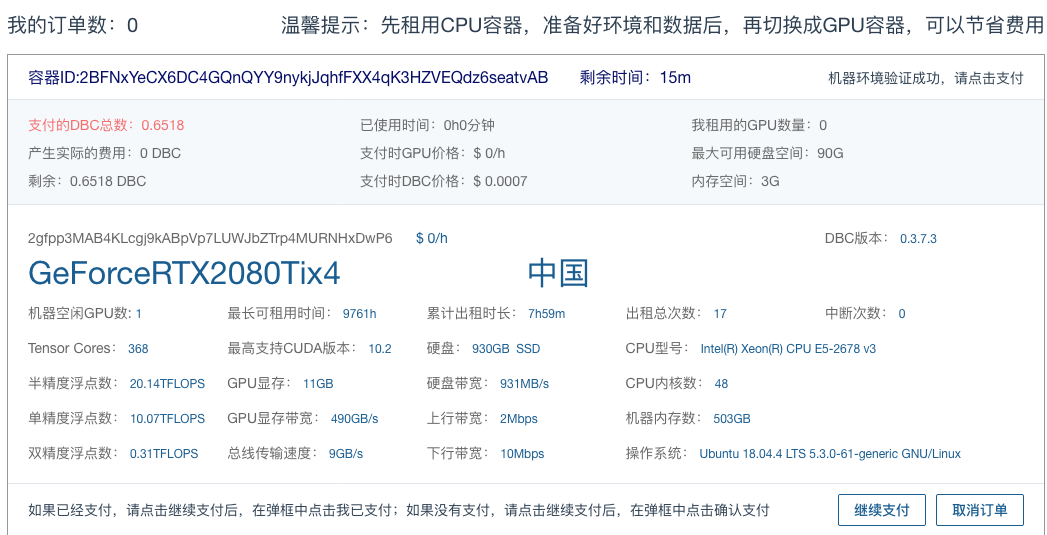

# XGBoost: A Scalable Tree Boosting System

In [7]:
from IPython.display import IFrame
IFrame('https://arxiv.org/pdf/1603.02754', width=1200, height=450)

## ABSTRACT
Tree boosting is a highly effective and widely used machine learning method.  In this paper, we describe a scalable end-to-end tree boosting system called XGBoost, which is used widely by data scientists to achieve state-of-the-art resultson many machine learning challenges.  We propose 
* a novel sparsity-aware algorithm for sparse data(一种新的稀疏数据稀疏感知算法
* weighted quantile sketch for approximate tree learning(加权分位数草图，用于近似树学习.

More importantly,we provide insights on cache access patterns, data compression and sharding to build a scalable tree boosting system.By combining these insights, XGBoost scales beyond billions of examples using far fewer resources than existing systems.

## TREE BOOSTING IN A NUTSHELL(极简单地 
We review gradient tree boosting algorithms in this section. The derivation follows from the same idea in existing literatures in gradient boosting. 

Specicially the second order method is originated from Friedman et al. [12]. We make minor improvements in the reguralized objective, which were found helpful in practice.


### Shrinkage and Column Subsampling

## SPLIT FINDING ALGORITHMS
### 3.1    Basic Exact Greedy Algorithm
One  of  the  key  problems  in  tree  learning  is  to  find  the best split as indicated by Eq (7).  In order to do so, a split finding algorithm enumerates over all the possible splits on all  the  features.   We  call  this  the exact greedy algorithm. Most existing single machine tree boosting implementations,such as scikit-learn [20], R’s gbm [21] as well as the single machine version of XGBoost support the exact greedy algo-rithm.  The exact greedy algorithm is shown in Alg. 1.  It is computationally demanding to enumerate all the possiblesplits for continuous features.  In order to do so efficiently,the algorithm must first sort the data according to featurevalues and visit the data in sorted order to accumulate the gradient statistics for the structure score in Eq (7).
### 3.2    Approximate Algorithm 
The exact greedy algorithm is very powerful since it enu-merates over all possible splitting points greedily.  However,it is impossible to efficiently do so when the data does not fit entirely into memory.  Same problem also arises in the distributed setting. To support effective gradient tree boosting in these two settings, an approximate algorithm is needed. 

We summarize an approximate framework, which resembles the ideas proposed in past literatures [17, 2, 22], in Alg. 2. To summarize, the algorithm first proposes can- didate splitting points according to percentiles of feature distribution (a specific criteria will be given in Sec. 3.3). The algorithm then maps the continuous features into buck- ets split by these candidate points, aggregates the statistics and finds the best solution among proposals based on the aggregated statistics. 

There are two variants of the algorithm, depending on when the proposal is given. 
* The global variant proposes all the candidate splits during the initial phase of tree construction, and uses the same proposals for split finding at all levels. 
* The local variant re-proposes after each split. 

The global method requires less proposal steps than the local method. However, usually more candidate points are needed for the global proposal because candidates are not refined after each split. 

The local proposal refines the candidates after splits, and can potentially be more appropriate for deeper trees. A comparison of different algorithms on a Higgs boson dataset is given by Fig. 3. We find that the 
* local proposal indeed requires fewer candidates. 
* The global proposal can be as accurate as the local one given enough candidates. 

Most existing approximate algorithms for distributed tree learning also follow this framework. Notably, it is also possible to directly construct approximate histograms of gradient statistics [22]. It is also possible to use other variants of bin- ning strategies instead of quantile [17]. Quantile strategy benefit from being distributable and recomputable, which we will detail in next subsection. From Fig. 3, we also find that the quantile strategy can get the same accuracy as exact greedy given reasonable approximation level. Our system efficiently supports exact greedy for the single machine setting, as well as approximate algorithm with both local and global proposal methods for all settings. Users can freely choose between the methods according to their needs.

### 3.3 Weighted Quantile Sketch 
One important step in the approximate algorithm is to propose candidate split points. Usually percentiles of a feature are used to make candidates distribute evenly on the data. 

Formally, let multi-set Dk = {(x1k, h1), (x2k, h2) · · · (xnk, hn)} represent the k-th feature values and second order gradient statistics of each training instances. We can define a rank functions rk :

which is exactly weighted squared loss with labels gi/hi and weights hi. For large datasets, it is non-trivial to find candidate splits that satisfy the criteria. When every in- stance has equal weights, an existing algorithm called quan- tile sketch [14, 24] solves the problem. However, there is no existing quantile sketch for the weighted datasets. There- fore, most existing approximate algorithms either resorted to sorting on a random subset of data which have a chance of failure or heuristics that do not have theoretical guarantee. To solve this problem, we introduced a novel distributed
weighted quantile sketch algorithm that can handle weighted data with a provable theoretical guarantee. The general idea is to propose a data structure that supports merge and prune operations, with each operation proven to maintain a certain accuracy level. A detailed description of the algorithm as well as proofs are given in the appendix.
### 3.4 Sparsity-aware Split Finding 
In many real-world problems, it is quite common for the input x to be sparse. There are multiple possible causes for sparsity: 
* 1) presence of missing values in the data; 
* 2) frequent zero entries in the statistics; and, 
* 3) artifacts of feature engineering such as one-hot encoding. 

It is important to make the algorithm aware of the sparsity pattern in the data. In order to do so, we propose to add a default direction in each tree node, which is shown in Fig. 4. When a value is missing in the sparse matrix x, the instance is classified into the default direction. There are two choices of default direction in each branch. The optimal default directions are learnt from the data. The algorithm is shown in Alg. 3. The key improvement is to only visit the non-missing entries Ik. The presented algorithm treats the non-presence as a missing value and learns the best direction to handle missing values. The same algorithm can also be applied when the non-presence corresponds to a user specified value by limiting the enumeration only to consistent solutions. 

To the best of our knowledge, most existing tree learning algorithms are either only optimized for dense data, or need specific procedures to handle limited cases such as categorical encoding. XGBoost handles all sparsity patterns in a unified way. More importantly, our method exploits the sparsity to make computation complexity linear to number of non-missing entries in the input. Fig. 5 shows the com- parison of sparsity aware and a naive implementation on an Allstate-10K dataset (description of dataset given in Sec. 6). We find that the sparsity aware algorithm runs 50 times faster than the naive version. This confirms the importance of the sparsity aware algorithm.

# 面试问题汇总
https://zhuanlan.zhihu.com/p/86816771

## 你有测试过Xgboost和GBDT的效果区别吗？你认为在你的项目上是什么导致原因导致了这个区别”
“是的，我们有试过，Xgboost的精度要比GBDT高而且效率也要更高。我认为精度高的最大原因是大部分的CTR特征中，我们会将一些高基类别的离散值转化为连续值，会产生很多含有缺失值的稀疏特征，而Xgboost会对缺失值做一个特殊的处理。效率高是因为建树时采用了更好的分割点估计算法”
## 对缺失值是怎么处理的？
在普通的GBDT策略中，对于缺失值的方法是先手动对缺失值进行填充，然后当做有值的特征进行处理，但是这样人工填充不一定准确，而且没有什么理论依据。

而Xgboost采取的策略是先不处理那些值缺失的样本，采用那些有值的样本搞出分裂点，然后在遍历每个分裂点的时候，尝试将缺失样本划入左子树和右子树，选择使损失最优的情况。”
## 你能讲一下Xgboost和GBDT的区别吗？”
“Xgboost是GBDT算法的一种很好的工程实现，并且在算法上做了一些优化，主要的优化在一下几点。
### shrinkage and col subsampling
* shrinkage，相当于一个学习率。好处：防止过拟合
* 还有增加了在随机森林上常用的col subsample的策略, 防止过拟合，加快训练速度 
* 其次是在原GBDT模型上加了个正则项，对于树的叶子节点的权重做了一个约束；
* 然后使用二阶泰勒展开去拟合损失函数，加快优化的效率；
* 然后最大的地方在于不需要遍历所有可能的分裂点了，它提出了一种估计分裂点的算法。
* 在工程上做了一个算法的并发实现，具体我并不了解如何实现的”

# lightgbm

In [8]:
from IPython.display import IFrame
IFrame('https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf', width=1200, height=450)

## Abstract
Gradient Boosting Decision Tree (GBDT) is a popular machine learning algo-rithm, and has quite a few effective implementations such as XGBoost and pGBRT.

Although many engineering optimizations have been adopted in these implemen-tations,  the  efficiency  and  scalability  are  still  unsatisfactory  when  the  feature dimension is high and data size is large. A major reason is that for each feature,they need to scan all the data instances to estimate the information gain of allpossible split points, which is very time consuming. 

To tackle this problem, wepropose two novel techniques:
* Gradient-based One-Side Sampling(GOSS) and 
With GOSS, we exclude a significant proportion of data instances with small gradients, and only use the rest to estimate the information gain. We prove that, since the data instances with larger gradients play a more important role in the computation of information gain, GOSS can obtain quite accurate estimation of the information gain with a much smaller data size.
* Exclusive Feature Bundling(EFB). 
With EFB, we bundle mutually exclusive features (i.e., they rarely take nonzero values simultaneously), to reduce the number of features. We prove that finding the optimal bundling of exclusive features is NP-hard, but a greedy algorithmcan achieve quite good approximation ratio (and thus can effectively reduce thenumber of features without hurting the accuracy of split point determination bymuch). We call our new GBDT implementation with GOSS and EFBLightGBM.

Our experiments on multiple public datasets show that, LightGBM speeds up thetraining process of conventional GBDT by up to over 20 times while achieving almost the same accuracy.

## 知乎文章

https://zhuanlan.zhihu.com/p/89360721

LGB选择梯度大的样本来计算信息增益。原文给出的理由如下：

    if an instance is associated with a small gradient, the training error for this instance is small and it is already well trained.

如果一个样本的梯度较小，证明这个样本训练的误差已经很小了，所以不需要计算了。我们在XGB的那篇文章中说过，GBDT的梯度算出来实际上就是残差，梯度小残差就小，所以该样本拟合较好，不需要去拟合他们了。

这听起来仿佛很有道理，但问题是丢掉他们会改变数据的分布，还是无法避免信息损失，进而导致精度下降，所以LGB提出了一个很朴实无华且枯燥的方法进行优化。

LGB的优化方法是，在保留大梯度样本的同时，随机地保留一些小梯度样本，同时放大了小梯度样本带来的信息增益。

这样说起来比较抽象，我们过一遍流程： 首先把样本按照梯度排序，选出梯度最大的a%个样本，然后在剩下小梯度数据中随机选取b%个样本，在计算信息增益的时候，将选出来b%个小梯度样本的信息增益扩大 1 - a / b 倍。这样就会避免对于数据分布的改变。

这给我的感觉就是一个公寓里本来住了十个人，感觉太挤了，赶走了六个人，但剩下的四个人要分摊他们六个人的房租。

除了通过部分样本计算信息增益以外，LGB还内置了特征降维技术，思想就是合并那些冲突小的稀疏特征。

举个例子，对于一列特征[1,nan,1,nan,1]和一列特征[nan,1,nan,1,nan]，他们正好可以合并成一列特征[1,2,1,2,1]。LGB的目标就是在于找到这样的特征并且将他们合并在一起。

如果把特征抽象成图中的点，特征之间的冲突看作是图中的边，那么问题就转换为找出图中的社团并使图中的社团数量最少。LGB里提出了一个贪心的策略，按照有权度来为图中所有的点排序，然后把特征合并到度小于某个阈值的社团中或单独创建一个社团。

对于特征如何合并，一个重要的原则就是使合并的两个特征可以被顺利区分出来，LGB采取了一个更改阈值的方法。例如对于特征x∈(0, 10)， 特征y∈(0, 20)，就可以把特征y转换为y∈(10,30)，然后再去合并x与y。

但是更多的情况，对于有数据科学经验的工程师，在使用前往往会避免在特征中掺杂大量稀疏属性。

## 至于LGB为什么比XGB的精度高这一点，
我的理解是选择梯度大(残差大)样本来进行特征分裂生成的树，借鉴了Adaboost的更改样本权重的思想。每棵树针对某些特定训练样本有着较好的划分能力，导致每棵树之间的异质性较大，对于效果近似但异质性大的模型加权往往会带来更大的提升。不知道诸位有没有更好的观点~